**Assumption:**
1. When a customer sees a product, the propensity of purchase matches Beta Distribution. The lower the price is, the higher possibility he or she will buy it.
2. A single customer's purchase prob matches Beta Distribution. Then the number of buyers matches Binomial Distribution. This is called Beta-Binomial distribution.

3. The candidates of the price is from 100, 105, 110, until 145. There are 10 prices on the list.

4. The cost of each product is 70.

5. We will maximize the profit by selecting the corresponding price.

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import random
from collections import Counter
import math

In [101]:
cost = 70

price_list = list(range(100, 150, 5))

a_list = [6, 5.5, 5, 5, 4, 3.5, 3, 2.5, 2, 1.5]

b_list = [4, 4.5, 5, 5, 6, 6.5, 7, 7.5, 8, 8.5]

prob_list = [a_list[i]/(a_list[i]+b_list[i]) for i in range(10)]
prob_list

[0.6, 0.55, 0.5, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15]

In [102]:
profit_list = [(price_list[i]-cost) for i in range(10)]
profit_list

[30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

In [103]:
profit_expected_list = [prob_list[i]*(price_list[i]-cost) for i in range(10)]
profit_expected_list

[18.0, 19.25, 20.0, 22.5, 20.0, 19.25, 18.0, 16.25, 14.0, 11.25]

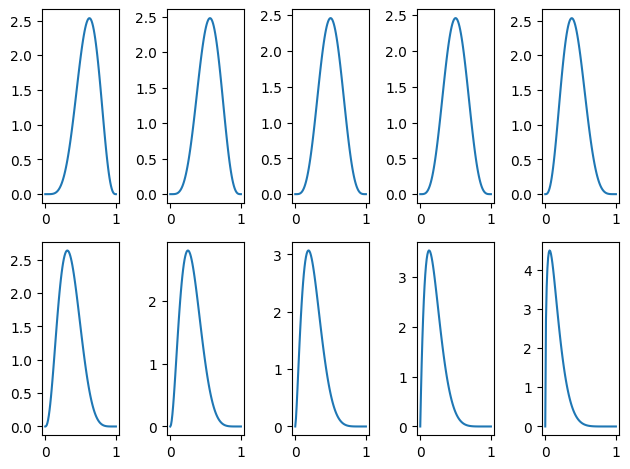

In [104]:
n_row = 2
n_col = 5

x = np.linspace(0, 1, 100)

figure, axis = plt.subplots(n_row, n_col)
for row in range(n_row):
  for col in range(n_col):
    ind = row*n_col + col
    y = beta.pdf(x, a_list[ind], b_list[ind])
    axis[row, col].plot(x, y)
    # axis[0, 0].set_title("Sine Function")

plt.tight_layout()
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

In [105]:
def sim_beta_bin(group_index, sample=100):
  res = beta.rvs(a_list[group_index], b_list[group_index], size = sample)
  r = np.random.binomial(1, res)
  return r


def epsilon_greedy(epsilon, prior_a_list, prior_b_list, profit_list):
  rnd = random.random()
  if rnd<epsilon:
    can = random.randint(0, 9)
    return can

  prob_list = [prior_a_list[i]/(prior_a_list[i] + prior_b_list[i]) for i in range(10)]
  profit_expected_list = [prob_list[i]*profit_list[i] for i in range(10)]
  can = profit_expected_list.index(max(profit_expected_list))
  return can


def update_post(can, exp_a_list, exp_b_list, sample):
  sim_res = sim_beta_bin(can, sample)
  pos_num = sum(sim_res)
  neg_num = sample - pos_num
  exp_a_list[can] = exp_a_list[can] + pos_num
  exp_b_list[can] = exp_b_list[can] + neg_num
  return exp_a_list, exp_b_list

def sim_process(prior_a_list=[1]*10, prior_b_list=[5]*10, steps=10000, epsilon=0.1, sample=100, champion=3):
  action = []
  champ_ratio = []
  acc_sum = 0
  for i in range(steps):
    can = epsilon_greedy(epsilon, prior_a_list, prior_b_list, profit_list)
    action.append(can)
    prior_a_list, prior_b_list = update_post(can, prior_a_list, prior_b_list, sample)
    if can == champion:
      acc_sum+=1
    champ_ratio.append(acc_sum/(i+1))

  return prior_a_list, prior_b_list, action, champ_ratio

In [120]:
prior_a_list_1, prior_b_list_1, action_1, champ_ratio_1 = sim_process(prior_a_list=[1]*10, prior_b_list=[10]*10, steps=10000, epsilon=0.1, sample=1000, champion=3)
prior_a_list_01, prior_b_list_01, action_01, champ_ratio_01 = sim_process(prior_a_list=[1]*10, prior_b_list=[10]*10, steps=10000, epsilon=0.01, sample=1000, champion=3)
# prior_a_list_0, prior_b_list_0, action_0, champ_ratio_0 = sim_process(prior_a_list=[1]*10, prior_b_list=[5]*10, steps=10000, epsilon=0, sample=1000, champion=3)
prior_a_list_rand, prior_b_list_rand, action_rand, champ_ratio_rand = sim_process(prior_a_list=[1]*10, prior_b_list=[10]*10, steps=10000, epsilon=1, sample=1000, champion=3)

In [125]:
def sim_process_decay(prior_a_list=[1]*10, prior_b_list=[5]*10, steps=10000, sample=100, champion=3):
  action = []
  champ_ratio = []
  acc_sum = 0
  epsilon = 1
  for i in range(steps):
    can = epsilon_greedy(epsilon, prior_a_list, prior_b_list, profit_list)
    action.append(can)
    prior_a_list, prior_b_list = update_post(can, prior_a_list, prior_b_list, sample)
    if can == champion:
      acc_sum+=1
    champ_ratio.append(acc_sum/(i+1))
    epsilon = 0.9*epsilon

  return prior_a_list, prior_b_list, action, champ_ratio

In [126]:
prior_a_list_decay, prior_b_list_decay, action_decay, champ_ratio_decay = sim_process_decay(prior_a_list=[1]*10, prior_b_list=[10]*10, steps=10000, sample=1000, champion=3)

In [143]:
def epsilon_greedy_ucb(epsilon, prior_a_list, prior_b_list, profit_list, t, action):
  rnd = random.random()
  if rnd<epsilon:
    can = random.randint(0, 9)
    return can

  prob_list = [prior_a_list[i]/(prior_a_list[i] + prior_b_list[i]) for i in range(10)]
  profit_expected_list = [prob_list[i]*profit_list[i] for i in range(10)]
  dic=Counter()
  for act in action:
    dic[act] += 1
  Nt = [dic[i] for i in range(10)]
  Ut = [2*math.sqrt(math.log(t)/max(100, x)) for x in Nt]
  profit_ucb_list = [profit_expected_list[i]+Ut[i] for i in range(10)]

  can = profit_ucb_list.index(max(profit_ucb_list))
  return can

In [144]:
def sim_process_ucb(prior_a_list=[1]*10, prior_b_list=[5]*10, steps=10000, sample=100, champion=3):
  action = []
  champ_ratio = []
  acc_sum = 0
  epsilon = 1
  for i in range(steps):
    can = epsilon_greedy_ucb(epsilon, prior_a_list, prior_b_list, profit_list, i, action)
    action.append(can)
    prior_a_list, prior_b_list = update_post(can, prior_a_list, prior_b_list, sample)
    if can == champion:
      acc_sum+=1
    champ_ratio.append(acc_sum/(i+1))
    epsilon = 0.9*epsilon

  return prior_a_list, prior_b_list, action, champ_ratio

In [145]:
prior_a_list_ucb, prior_b_list_ucb, action_ucb, champ_ratio_ucb = sim_process_ucb(prior_a_list=[1]*10, prior_b_list=[10]*10, steps=10000, sample=1000, champion=3)

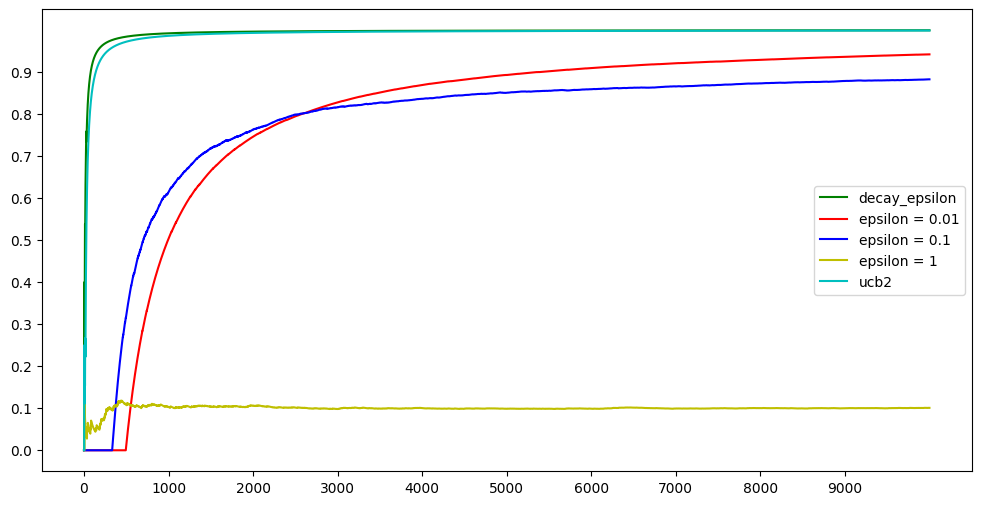

In [148]:
plt.figure(figsize=(12,6))
plt.xticks(np.arange(0,10000,1000))
plt.yticks(np.arange(0,1,0.1))
plt.plot(champ_ratio_decay, 'g', label='decay_epsilon')
plt.plot(champ_ratio_01, 'r', label='epsilon = 0.01')
plt.plot(champ_ratio_1, 'b', label='epsilon = 0.1')
plt.plot(champ_ratio_rand, 'y', label='epsilon = 1')
plt.plot(champ_ratio_ucb, 'c', label='ucb2')
plt.legend()
plt.show()